In [31]:
import warnings
warnings.filterwarnings('ignore')

import os 
import json 
import pandas as pd 
import torch
from PIL import Image
from transformers import ViltProcessor
from transformers import ViltForQuestionAnswering
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm 

torch.cuda.is_available()


True

In [4]:
class Config:
    base_dir = os.path.dirname(os.getcwd())
    data_dir = os.path.join(base_dir, 'dataset')
    image_dir = os.path.join(data_dir, 'images')
    train_file = 'data_train.csv'
    eval_file = 'data_eval.csv'
    answer_space_file = 'answer_space.txt'

cfg = Config()

In [5]:
with open(os.path.join(cfg.data_dir, cfg.answer_space_file)) as f:
    answer_space = f.readlines()
answer_space = [ans.strip() for ans in answer_space]

train_df = pd.read_csv(os.path.join(cfg.data_dir, cfg.train_file))
eval_df = pd.read_csv(os.path.join(cfg.data_dir, cfg.eval_file))

print(f"Train Data Size : {len(train_df)}")
print(f"Eval Data Size : {len(eval_df)}")

Train Data Size : 9974
Eval Data Size : 2494


In [6]:
label2id = {label:idx for idx, label in enumerate(answer_space)}
id2label = {v:k for k,v in label2id.items()}

In [7]:
def prepare_annotations(data_df : pd.DataFrame, label2id : dict) -> dict: 
    annotations = []
    for idx,row in data_df.iterrows():
        question = row['question']
        image_id = row['image_id']
        answer = [ans.strip() for ans in row['answer'].split(',')]
        answer_count = {}
        for answer_ in answer:
            answer_count[answer_] = answer_count.get(answer_, 0) + 1
        
        labels = []
        scores = []
        for answer_ in answer_count:
            labels.append(label2id[str(answer_)])
            scores.append(1.0)
        
        annotations_dict = {
            'question' : question,
            'image_id' : image_id,
            'answer' : answer,
            'labels' : labels,
            'scores' : scores
        }
        annotations.append(annotations_dict)
    return annotations


In [8]:
train_annotations = prepare_annotations(data_df = train_df, label2id = label2id)
eval_annotations = prepare_annotations(data_df = eval_df, label2id = label2id)

In [9]:
train_annotations[0]

{'question': 'what is the object on the shelves',
 'image_id': 'image100',
 'answer': ['cup'],
 'labels': [149],
 'scores': [1.0]}

In [10]:
class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, annotations, processor, image_dir, id2label):
        self.annotations = annotations
        self.processor = processor
        self.image_dir = image_dir
        self.id2label = id2label

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # get image + text
        annotation = self.annotations[idx]
        image_id = annotation['image_id']
        image = Image.open(os.path.join(self.image_dir, f'{image_id}.png'))
        text = annotation['question']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        labels = annotation['labels']
        scores = annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(self.id2label))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets
        return encoding

In [11]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [12]:
dataset = VQADataset(annotations=train_annotations[:100],
                     processor=processor,
                     image_dir=cfg.image_dir,
                     id2label=id2label
                     )

In [13]:
dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [14]:
processor.decode(dataset[0]['input_ids'])

'[CLS] what is the object on the shelves [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [15]:
labels = np.array(torch.nonzero(dataset[0]['labels']))[0].tolist()
[id2label[label] for label in labels]

['cup']

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=id2label,
                                                 label2id=label2id)
model.to(device)

cuda


Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [18]:
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)

In [19]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 40])
attention_mask torch.Size([4, 40])
token_type_ids torch.Size([4, 40])
pixel_values torch.Size([4, 3, 384, 480])
pixel_mask torch.Size([4, 384, 480])
labels torch.Size([4, 582])


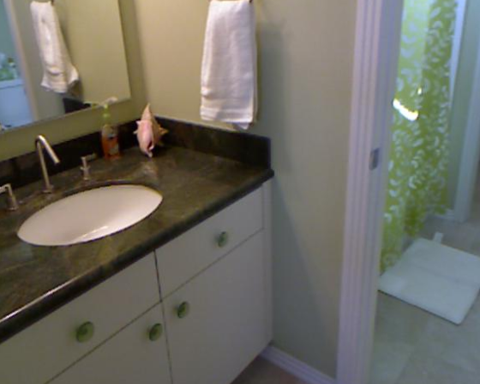

In [20]:
from PIL import Image
import numpy as np

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [21]:
processor.decode(batch["input_ids"][batch_idx])

'[CLS] how many knobs in wash basin cupboard [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [30]:
labels = np.array(torch.nonzero(batch['labels'][batch_idx]))[0].tolist()
[id2label[label] for label in labels]

['4']

In [32]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 425.2691650390625


  8%|▊         | 2/25 [00:11<01:50,  4.79s/it]

Loss: 404.323486328125


 12%|█▏        | 3/25 [00:11<00:59,  2.71s/it]

Loss: 391.82470703125


 16%|█▌        | 4/25 [00:11<00:36,  1.72s/it]

Loss: 377.5871887207031
Loss: 363.0151062011719


 24%|██▍       | 6/25 [00:12<00:15,  1.20it/s]

Loss: 347.85638427734375
Loss: 340.8168640136719


 32%|███▏      | 8/25 [00:12<00:08,  2.06it/s]

Loss: 329.551025390625
Loss: 312.6673889160156


 40%|████      | 10/25 [00:13<00:04,  3.06it/s]

Loss: 300.1237487792969
Loss: 291.83587646484375


 48%|████▊     | 12/25 [00:13<00:03,  3.96it/s]

Loss: 273.43109130859375
Loss: 264.3916015625


 56%|█████▌    | 14/25 [00:13<00:02,  4.63it/s]

Loss: 250.4076690673828
Loss: 248.8280792236328


 64%|██████▍   | 16/25 [00:14<00:01,  5.08it/s]

Loss: 231.21441650390625
Loss: 221.11509704589844


 72%|███████▏  | 18/25 [00:14<00:01,  5.27it/s]

Loss: 212.3113555908203
Loss: 203.56735229492188


 84%|████████▍ | 21/25 [00:15<00:00,  5.49it/s]

Loss: 195.79930114746094
Loss: 187.97677612304688


 88%|████████▊ | 22/25 [00:15<00:00,  5.51it/s]

Loss: 179.88577270507812
Loss: 173.15870666503906


 96%|█████████▌| 24/25 [00:15<00:00,  5.43it/s]

Loss: 166.84754943847656
Loss: 160.6630096435547


100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


Epoch: 1


  4%|▍         | 1/25 [00:00<00:04,  5.73it/s]

Loss: 152.10829162597656
Loss: 147.7076873779297


  8%|▊         | 2/25 [00:00<00:04,  5.63it/s]

Loss: 141.27545166015625


 12%|█▏        | 3/25 [00:00<00:03,  5.59it/s]

Loss: 137.51766967773438


 16%|█▌        | 4/25 [00:00<00:03,  5.59it/s]

Loss: 132.77035522460938


 20%|██        | 5/25 [00:00<00:03,  5.43it/s]

Loss: 128.95860290527344


 28%|██▊       | 7/25 [00:01<00:03,  5.68it/s]

Loss: 122.04342651367188


 32%|███▏      | 8/25 [00:01<00:02,  5.76it/s]

Loss: 118.15435028076172
Loss: 115.27779388427734


 40%|████      | 10/25 [00:01<00:02,  5.79it/s]

Loss: 111.0033187866211


 44%|████▍     | 11/25 [00:01<00:02,  5.82it/s]

Loss: 108.13402557373047


 48%|████▊     | 12/25 [00:02<00:02,  5.84it/s]

Loss: 103.67483520507812


 52%|█████▏    | 13/25 [00:02<00:02,  5.86it/s]

Loss: 100.86664581298828


 56%|█████▌    | 14/25 [00:02<00:01,  5.85it/s]

Loss: 97.23257446289062


 60%|██████    | 15/25 [00:02<00:01,  5.85it/s]

Loss: 94.82736206054688


 64%|██████▍   | 16/25 [00:02<00:01,  5.88it/s]

Loss: 91.51677703857422


 68%|██████▊   | 17/25 [00:02<00:01,  5.87it/s]

Loss: 89.3282470703125


 72%|███████▏  | 18/25 [00:03<00:01,  5.90it/s]

Loss: 85.69988250732422


 76%|███████▌  | 19/25 [00:03<00:01,  5.91it/s]

Loss: 83.59541320800781


 80%|████████  | 20/25 [00:03<00:00,  5.94it/s]

Loss: 81.66270446777344
Loss: 79.13343811035156


 88%|████████▊ | 22/25 [00:03<00:00,  5.82it/s]

Loss: 76.46836853027344


 92%|█████████▏| 23/25 [00:03<00:00,  5.86it/s]

Loss: 74.84288787841797
Loss: 72.35034942626953


 96%|█████████▌| 24/25 [00:04<00:00,  5.67it/s]

Loss: 70.10867309570312


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Epoch: 2


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 68.16934204101562


  4%|▍         | 1/25 [00:00<00:04,  5.44it/s]

Loss: 67.07691955566406


  8%|▊         | 2/25 [00:00<00:04,  5.46it/s]

Loss: 64.90728759765625


 16%|█▌        | 4/25 [00:00<00:03,  5.77it/s]

Loss: 62.94879150390625


 20%|██        | 5/25 [00:00<00:03,  5.85it/s]

Loss: 61.576324462890625
Loss: 60.05860900878906


 24%|██▍       | 6/25 [00:01<00:03,  5.70it/s]

Loss: 58.17237854003906


 32%|███▏      | 8/25 [00:01<00:02,  5.79it/s]

Loss: 57.53548812866211


 36%|███▌      | 9/25 [00:01<00:02,  5.91it/s]

Loss: 55.5828742980957


 40%|████      | 10/25 [00:01<00:02,  6.03it/s]

Loss: 54.17786407470703


 44%|████▍     | 11/25 [00:01<00:02,  6.10it/s]

Loss: 53.569766998291016


 48%|████▊     | 12/25 [00:02<00:02,  6.07it/s]

Loss: 51.815879821777344


 52%|█████▏    | 13/25 [00:02<00:01,  6.07it/s]

Loss: 51.97334671020508


 56%|█████▌    | 14/25 [00:02<00:01,  6.06it/s]

Loss: 50.38505172729492


 60%|██████    | 15/25 [00:02<00:01,  6.04it/s]

Loss: 49.50676727294922


 64%|██████▍   | 16/25 [00:02<00:01,  6.00it/s]

Loss: 47.16627502441406
Loss: 47.04303741455078


 68%|██████▊   | 17/25 [00:02<00:01,  5.88it/s]

Loss: 45.26360321044922


 76%|███████▌  | 19/25 [00:03<00:01,  5.31it/s]

Loss: 45.35395431518555


 80%|████████  | 20/25 [00:03<00:00,  5.00it/s]

Loss: 43.57355499267578


 88%|████████▊ | 22/25 [00:03<00:00,  5.28it/s]

Loss: 42.49504089355469
Loss: 41.82928466796875


 96%|█████████▌| 24/25 [00:04<00:00,  5.56it/s]

Loss: 40.74641036987305
Loss: 42.099788665771484


100%|██████████| 25/25 [00:04<00:00,  5.69it/s]


Loss: 39.42588424682617
Epoch: 3


  4%|▍         | 1/25 [00:00<00:04,  5.94it/s]

Loss: 38.85767364501953


  8%|▊         | 2/25 [00:00<00:03,  6.00it/s]

Loss: 38.84052276611328


 12%|█▏        | 3/25 [00:00<00:03,  6.06it/s]

Loss: 37.06587219238281


 16%|█▌        | 4/25 [00:00<00:03,  6.07it/s]

Loss: 36.70106887817383


 20%|██        | 5/25 [00:00<00:03,  6.03it/s]

Loss: 36.11408233642578


 24%|██▍       | 6/25 [00:00<00:03,  6.03it/s]

Loss: 36.987701416015625


 28%|██▊       | 7/25 [00:01<00:03,  5.99it/s]

Loss: 34.930503845214844


 32%|███▏      | 8/25 [00:01<00:02,  5.98it/s]

Loss: 34.38323211669922


 36%|███▌      | 9/25 [00:01<00:02,  5.99it/s]

Loss: 33.65675735473633


 40%|████      | 10/25 [00:01<00:02,  5.97it/s]

Loss: 33.78895950317383
Loss: 32.71385955810547


 44%|████▍     | 11/25 [00:01<00:02,  5.78it/s]

Loss: 33.072593688964844


 56%|█████▌    | 14/25 [00:02<00:02,  5.48it/s]

Loss: 32.5177116394043
Loss: 31.28904151916504


 64%|██████▍   | 16/25 [00:02<00:01,  5.69it/s]

Loss: 31.811588287353516
Loss: 30.28235626220703


 68%|██████▊   | 17/25 [00:02<00:01,  5.30it/s]

Loss: 30.575841903686523


 72%|███████▏  | 18/25 [00:03<00:01,  5.10it/s]

Loss: 29.537439346313477


 76%|███████▌  | 19/25 [00:03<00:01,  5.01it/s]

Loss: 29.166240692138672


 80%|████████  | 20/25 [00:03<00:01,  4.94it/s]

Loss: 30.185096740722656


 84%|████████▍ | 21/25 [00:03<00:00,  4.87it/s]

Loss: 28.34797477722168


 88%|████████▊ | 22/25 [00:04<00:00,  4.84it/s]

Loss: 27.871261596679688


 92%|█████████▏| 23/25 [00:04<00:00,  4.80it/s]

Loss: 27.386884689331055


 96%|█████████▌| 24/25 [00:04<00:00,  4.80it/s]

Loss: 28.202608108520508


100%|██████████| 25/25 [00:04<00:00,  5.36it/s]


Loss: 26.835002899169922
Epoch: 4


  4%|▍         | 1/25 [00:00<00:05,  4.70it/s]

Loss: 26.328901290893555
Loss: 25.853195190429688


 12%|█▏        | 3/25 [00:00<00:04,  5.30it/s]

Loss: 26.53316879272461
Loss: 25.458133697509766


 20%|██        | 5/25 [00:00<00:03,  5.58it/s]

Loss: 24.969274520874023
Loss: 25.540597915649414


 28%|██▊       | 7/25 [00:01<00:03,  5.61it/s]

Loss: 26.007287979125977
Loss: 24.186574935913086


 40%|████      | 10/25 [00:01<00:02,  5.70it/s]

Loss: 24.848655700683594
Loss: 23.789222717285156


 44%|████▍     | 11/25 [00:01<00:02,  5.69it/s]

Loss: 24.17074966430664
Loss: 23.091236114501953


 52%|█████▏    | 13/25 [00:02<00:02,  5.59it/s]

Loss: 22.99410057067871
Loss: 22.537981033325195


 60%|██████    | 15/25 [00:02<00:01,  5.62it/s]

Loss: 22.322690963745117
Loss: 23.580575942993164


 68%|██████▊   | 17/25 [00:03<00:01,  5.52it/s]

Loss: 21.662189483642578
Loss: 22.822216033935547


 76%|███████▌  | 19/25 [00:03<00:01,  5.52it/s]

Loss: 23.224811553955078
Loss: 21.435531616210938


 88%|████████▊ | 22/25 [00:03<00:00,  5.60it/s]

Loss: 21.191686630249023
Loss: 20.640249252319336


 92%|█████████▏| 23/25 [00:04<00:00,  5.58it/s]

Loss: 21.383771896362305
Loss: 20.47902488708496


100%|██████████| 25/25 [00:04<00:00,  5.55it/s]


Loss: 20.100189208984375
Epoch: 5


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 20.157978057861328


  8%|▊         | 2/25 [00:00<00:04,  4.85it/s]

Loss: 20.87440299987793
Loss: 19.562637329101562


 16%|█▌        | 4/25 [00:00<00:04,  4.60it/s]

Loss: 19.308025360107422


 24%|██▍       | 6/25 [00:01<00:03,  5.23it/s]

Loss: 19.066139221191406
Loss: 21.240856170654297


 32%|███▏      | 8/25 [00:01<00:03,  5.56it/s]

Loss: 18.96094512939453
Loss: 19.42521858215332


 40%|████      | 10/25 [00:01<00:02,  5.58it/s]

Loss: 18.708362579345703
Loss: 18.71211814880371


 44%|████▍     | 11/25 [00:02<00:02,  5.56it/s]

Loss: 18.309934616088867
Loss: 18.254531860351562


 56%|█████▌    | 14/25 [00:02<00:01,  5.57it/s]

Loss: 19.598133087158203
Loss: 17.694639205932617


 64%|██████▍   | 16/25 [00:02<00:01,  5.75it/s]

Loss: 20.378021240234375
Loss: 18.47456169128418


 68%|██████▊   | 17/25 [00:03<00:01,  5.74it/s]

Loss: 17.46014976501465
Loss: 16.977432250976562


 80%|████████  | 20/25 [00:03<00:00,  5.73it/s]

Loss: 17.156917572021484
Loss: 17.005050659179688


 88%|████████▊ | 22/25 [00:03<00:00,  5.80it/s]

Loss: 17.02402114868164
Loss: 16.708724975585938


 96%|█████████▌| 24/25 [00:04<00:00,  5.89it/s]

Loss: 17.635318756103516
Loss: 16.3331298828125


100%|██████████| 25/25 [00:04<00:00,  5.53it/s]


Loss: 16.367870330810547
Epoch: 6


  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 16.217613220214844


  8%|▊         | 2/25 [00:00<00:03,  5.78it/s]

Loss: 17.859766006469727


 12%|█▏        | 3/25 [00:00<00:03,  5.86it/s]

Loss: 15.597408294677734
Loss: 16.84740447998047


 16%|█▌        | 4/25 [00:00<00:03,  5.58it/s]

Loss: 16.009021759033203


 20%|██        | 5/25 [00:00<00:03,  5.61it/s]

Loss: 16.54191780090332


 28%|██▊       | 7/25 [00:01<00:03,  5.38it/s]

Loss: 18.79615020751953
Loss: 16.517009735107422


 36%|███▌      | 9/25 [00:01<00:02,  5.54it/s]

Loss: 15.21475601196289
Loss: 15.341926574707031


 44%|████▍     | 11/25 [00:01<00:02,  5.60it/s]

Loss: 14.899173736572266
Loss: 15.08072566986084


 52%|█████▏    | 13/25 [00:02<00:02,  5.34it/s]

Loss: 15.331876754760742
Loss: 14.700691223144531


 60%|██████    | 15/25 [00:02<00:01,  5.50it/s]

Loss: 14.681914329528809
Loss: 14.406885147094727


 72%|███████▏  | 18/25 [00:03<00:01,  5.60it/s]

Loss: 14.730785369873047
Loss: 14.355514526367188


 80%|████████  | 20/25 [00:03<00:00,  5.86it/s]

Loss: 14.311148643493652
Loss: 15.247238159179688


 88%|████████▊ | 22/25 [00:03<00:00,  6.03it/s]

Loss: 14.250117301940918
Loss: 14.258495330810547


 96%|█████████▌| 24/25 [00:04<00:00,  6.06it/s]

Loss: 14.053555488586426
Loss: 14.098101615905762


100%|██████████| 25/25 [00:04<00:00,  5.62it/s]


Loss: 15.667123794555664
Epoch: 7


  4%|▍         | 1/25 [00:00<00:05,  4.65it/s]

Loss: 13.719781875610352


  8%|▊         | 2/25 [00:00<00:04,  4.63it/s]

Loss: 13.836958885192871


 12%|█▏        | 3/25 [00:00<00:04,  4.59it/s]

Loss: 14.620713233947754


 16%|█▌        | 4/25 [00:00<00:04,  4.63it/s]

Loss: 14.565143585205078


 20%|██        | 5/25 [00:01<00:04,  4.62it/s]

Loss: 14.271919250488281


 24%|██▍       | 6/25 [00:01<00:04,  4.61it/s]

Loss: 13.174638748168945


 28%|██▊       | 7/25 [00:01<00:03,  4.62it/s]

Loss: 13.302018165588379


 32%|███▏      | 8/25 [00:01<00:03,  4.60it/s]

Loss: 15.110912322998047


 36%|███▌      | 9/25 [00:01<00:03,  4.58it/s]

Loss: 13.201642036437988


 40%|████      | 10/25 [00:02<00:03,  4.60it/s]

Loss: 15.481061935424805


 44%|████▍     | 11/25 [00:02<00:03,  4.60it/s]

Loss: 12.86782455444336


 48%|████▊     | 12/25 [00:02<00:02,  4.62it/s]

Loss: 13.289505004882812


 52%|█████▏    | 13/25 [00:02<00:02,  4.64it/s]

Loss: 13.14760971069336


 56%|█████▌    | 14/25 [00:03<00:02,  4.65it/s]

Loss: 13.74453353881836


 60%|██████    | 15/25 [00:03<00:02,  4.70it/s]

Loss: 12.718704223632812
Loss: 13.617925643920898


 72%|███████▏  | 18/25 [00:03<00:01,  5.10it/s]

Loss: 12.55802059173584
Loss: 12.517749786376953


 76%|███████▌  | 19/25 [00:03<00:01,  5.19it/s]

Loss: 14.636574745178223
Loss: 12.40234661102295


 88%|████████▊ | 22/25 [00:04<00:00,  5.68it/s]

Loss: 12.590389251708984
Loss: 12.399307250976562


 96%|█████████▌| 24/25 [00:04<00:00,  5.97it/s]

Loss: 12.18930721282959
Loss: 12.167122840881348


100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Loss: 12.305900573730469
Epoch: 8


  4%|▍         | 1/25 [00:00<00:04,  5.95it/s]

Loss: 12.350105285644531


  8%|▊         | 2/25 [00:00<00:03,  6.16it/s]

Loss: 12.010941505432129
Loss: 12.037097930908203


 16%|█▌        | 4/25 [00:00<00:03,  5.70it/s]

Loss: 14.010049819946289
Loss: 11.763019561767578


 24%|██▍       | 6/25 [00:01<00:03,  5.87it/s]

Loss: 11.843602180480957


 28%|██▊       | 7/25 [00:01<00:02,  6.01it/s]

Loss: 11.763894081115723


 32%|███▏      | 8/25 [00:01<00:02,  6.10it/s]

Loss: 13.499509811401367


 36%|███▌      | 9/25 [00:01<00:02,  6.18it/s]

Loss: 13.434856414794922


 40%|████      | 10/25 [00:01<00:02,  6.21it/s]

Loss: 11.681042671203613


 44%|████▍     | 11/25 [00:01<00:02,  6.21it/s]

Loss: 12.405447959899902


 48%|████▊     | 12/25 [00:01<00:02,  6.23it/s]

Loss: 12.576934814453125


 52%|█████▏    | 13/25 [00:02<00:01,  6.28it/s]

Loss: 11.337295532226562


 56%|█████▌    | 14/25 [00:02<00:01,  6.20it/s]

Loss: 11.351520538330078


 60%|██████    | 15/25 [00:02<00:01,  6.25it/s]

Loss: 13.342046737670898


 68%|██████▊   | 17/25 [00:02<00:01,  5.83it/s]

Loss: 12.209096908569336
Loss: 11.0391263961792


 72%|███████▏  | 18/25 [00:02<00:01,  5.95it/s]

Loss: 11.157995223999023


 76%|███████▌  | 19/25 [00:03<00:01,  5.40it/s]

Loss: 11.242587089538574


 80%|████████  | 20/25 [00:03<00:00,  5.04it/s]

Loss: 11.14409351348877


 84%|████████▍ | 21/25 [00:03<00:00,  4.93it/s]

Loss: 11.786961555480957


 88%|████████▊ | 22/25 [00:03<00:00,  4.93it/s]

Loss: 11.455907821655273


 92%|█████████▏| 23/25 [00:04<00:00,  4.92it/s]

Loss: 11.128339767456055


 96%|█████████▌| 24/25 [00:04<00:00,  4.91it/s]

Loss: 10.862338066101074


100%|██████████| 25/25 [00:04<00:00,  5.58it/s]


Loss: 11.193428039550781
Epoch: 9


  4%|▍         | 1/25 [00:00<00:03,  6.24it/s]

Loss: 11.127939224243164


  8%|▊         | 2/25 [00:00<00:03,  6.18it/s]

Loss: 12.7664794921875


 12%|█▏        | 3/25 [00:00<00:03,  6.21it/s]

Loss: 10.928024291992188


 16%|█▌        | 4/25 [00:00<00:03,  6.28it/s]

Loss: 10.447422981262207


 20%|██        | 5/25 [00:00<00:03,  6.27it/s]

Loss: 10.242756843566895


 24%|██▍       | 6/25 [00:00<00:03,  6.04it/s]

Loss: 10.453657150268555


 28%|██▊       | 7/25 [00:01<00:02,  6.04it/s]

Loss: 11.369429588317871


 32%|███▏      | 8/25 [00:01<00:02,  6.09it/s]

Loss: 10.810458183288574


 36%|███▌      | 9/25 [00:01<00:02,  6.11it/s]

Loss: 10.527034759521484


 40%|████      | 10/25 [00:01<00:02,  6.17it/s]

Loss: 10.528240203857422


 44%|████▍     | 11/25 [00:01<00:02,  6.20it/s]

Loss: 10.828508377075195


 48%|████▊     | 12/25 [00:01<00:02,  6.22it/s]

Loss: 10.346370697021484


 52%|█████▏    | 13/25 [00:02<00:01,  6.17it/s]

Loss: 12.41687297821045


 56%|█████▌    | 14/25 [00:02<00:01,  5.55it/s]

Loss: 10.75363540649414


 60%|██████    | 15/25 [00:02<00:01,  5.28it/s]

Loss: 10.39760684967041


 64%|██████▍   | 16/25 [00:02<00:01,  5.13it/s]

Loss: 11.270627975463867


 68%|██████▊   | 17/25 [00:02<00:01,  5.01it/s]

Loss: 12.217559814453125


 72%|███████▏  | 18/25 [00:03<00:01,  4.96it/s]

Loss: 10.11866283416748


 76%|███████▌  | 19/25 [00:03<00:01,  4.93it/s]

Loss: 11.26234245300293


 80%|████████  | 20/25 [00:03<00:01,  4.89it/s]

Loss: 10.287307739257812


 84%|████████▍ | 21/25 [00:03<00:00,  4.86it/s]

Loss: 10.77889633178711


 88%|████████▊ | 22/25 [00:03<00:00,  4.84it/s]

Loss: 11.306313514709473


 92%|█████████▏| 23/25 [00:04<00:00,  4.79it/s]

Loss: 11.101314544677734


 96%|█████████▌| 24/25 [00:04<00:00,  4.77it/s]

Loss: 10.097304344177246


100%|██████████| 25/25 [00:04<00:00,  5.40it/s]

Loss: 10.247981071472168
